In [52]:
# INIT
!git clone -q https: // github.com/AlpaslanErdag/cardata
import random
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
import glob
import pandas as pd
import cv2
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam  # - Works
from keras.models import Sequential
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import imutils



fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --reject-shallow      don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --recursive ...       alias of --recurse-submodules
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --refere

In [53]:
# FUNCTIONS
def load_img_steering(datadir, df):
    image_path = []
    angle = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        image_path.append(os.path.join(datadir, image_id))
        angle.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    angles = np.asarray(angle)
    image_ids = np.asarray(image_id)
    return image_paths, angles


def load_speed_img(datadir, df):
    image_path1 = []
    speed1 = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        image_path1.append(os.path.join(datadir, image_id))
        speed1.append((indexed_data[2]))
    image_paths1 = np.asarray(image_path1)
    speeds1 = np.asarray(speed1)
    return image_paths1, speeds1


def load_test_img(datadir, df):
    test_path = []

    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        test_path.append(os.path.join(datadir, image_id))
        test_paths = np.asarray(test_path)

    return test_paths


def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


def img_random_brightness(image):
    brightness = iaa.Multiply((0.4, 1.2))
    image = brightness.augment_image(image)
    return image


def img_random_flip(image, angle):
    image = cv2.flip(image, 1)
    angle = 1 - angle
    return image, angle


def blur(image):
    kernel_size = random.randint(
        1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image, (kernel_size, kernel_size))

    return image


def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle


def angle_preprocess(img):
    #img = img[50:,:,:]
    img = img[int(img.shape[0] / 2):, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    #img = cv2.resize(img, (200, 66))
    img = (img * 255).astype(np.uint8)
    img = cv2.Canny(img, 100, 200)
    img = cv2.merge((img, img, img))
    img = cv2.resize(img, (200, 66))
    #img = img / 255.0
    #img = np.true_divide(image, 255, dtype=np.float32,casting="unsafe")
    return img


def speed_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.resize(image, (200, 66))
    # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # lower = np.array([0, 164, 0])
    # upper = np.array([179, 255, 255])
    # mask = cv2.inRange(hsv, lower, upper)
    # image = cv2.bitwise_and(image, image, mask = mask)
    #image = image[int(image.shape[0] / 4):, :, :]
    return image


def angle_batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(
                0,
                len(image_paths) - 1
            )  # Picks random image in the dataset, creating a random batch of size batch_size

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )  # If training data, augment the image

            else:
                im = mpimg.imread(
                    image_paths[random_index])  # If not, just load image
                steering = steering_ang[random_index]

            im = angle_preprocess(im)  # Pass image through pipeline
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering)
               )  # Returns generator/ lazy iterator


def speed_batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(
                0,
                len(image_paths) - 1
            )  # Picks random image in the dataset, creating a random batch of size batch_size

            if istraining:
                im = mpimg.imread(image_paths[random_index])  # Add image to dataset
                steering = steering_ang[random_index]

                # Also augment the data and add to the dataset. Can loop here to increase dataset size
                for i in range(3):
                    im_aug, steering_aug = random_augment(image_paths[random_index], steering_ang[random_index])  
                    im_aug = speed_preprocess(im_aug)
                    batch_img.append(im_aug)
                    batch_steering.append(steering_aug)

            else:
                im = mpimg.imread(
                    image_paths[random_index])  # If not, just load image
                steering = steering_ang[random_index]

            im = speed_preprocess(im)  # Pass image through pipeline
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))  # Returns generator/ lazy iterator


def nvidia_model():

    model = Sequential()

    model.add(
        Conv2D(24,
               kernel_size=(5, 5),
               strides=(2, 2),
               input_shape=(66, 200, 3),
               activation='elu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optimizer)

    return model


In [54]:
datadir = "cardata"  # Define car data diretory
columns = ["image_id", "angle", "speed"]

# Read training data in from CSV
data = pd.read_csv(os.path.join(datadir, "training_norm3.csv"))

# Load angle/steering data
image_paths, angles = load_img_steering(
    datadir + "/training_data/training_data", data)

# Generate training/test split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,
                                                      angles,
                                                      test_size=0.2,
                                                      random_state=3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)
(66, 200, 3)


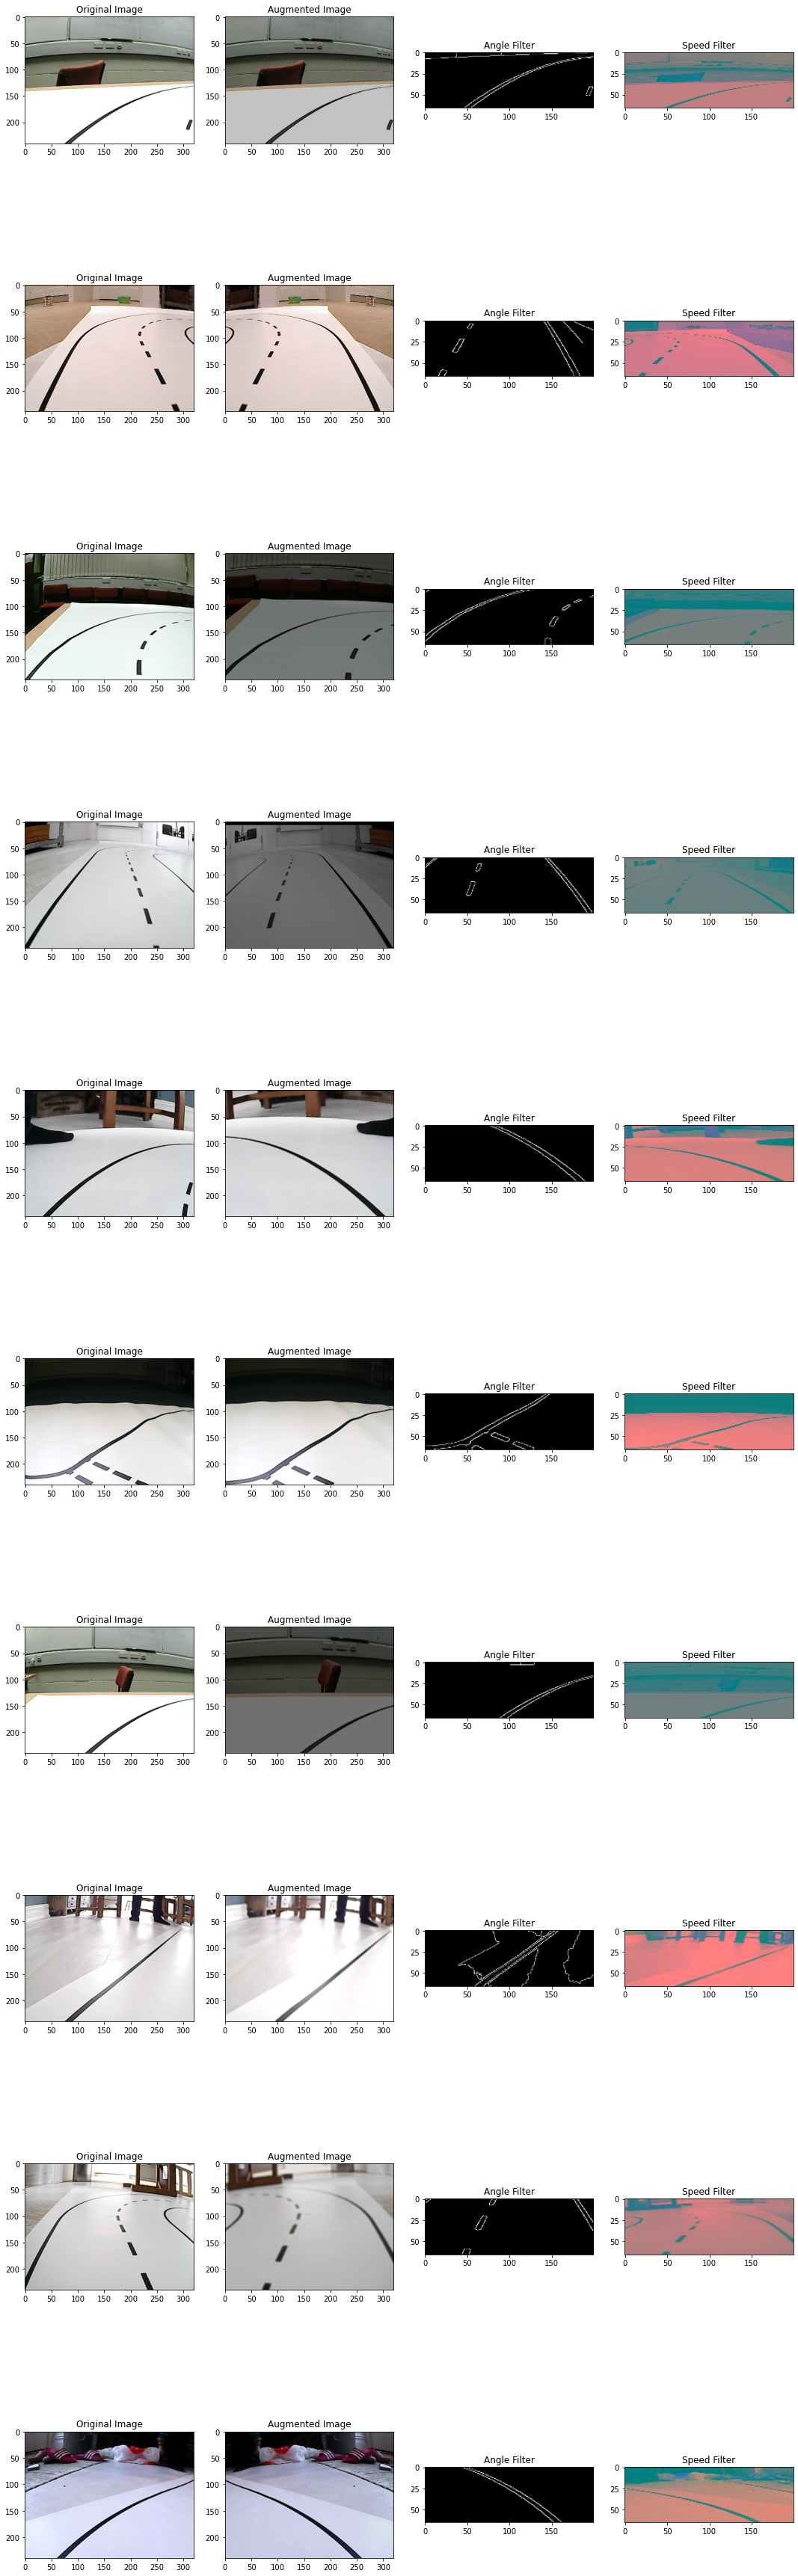

In [55]:
ncol = 4
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = angles[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  angle_image = angle_preprocess(augmented_image)
  speed_image = speed_preprocess(augmented_image)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

  axs[i][2].imshow(angle_image)
  axs[i][2].set_title("Angle Filter")

  axs[i][3].imshow(speed_image)
  axs[i][3].set_title("Speed Filter")
  print(speed_image.shape)

In [56]:
# TRAIN ANGLE MODEL
angle_model = nvidia_model()
batch_size = 64
steps_per_epoch = X_train.size/batch_size
angle_history = angle_model.fit(angle_batch_generator(X_train, y_train, batch_size,
                                                      1),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data=angle_batch_generator(
                                    X_valid, y_valid, batch_size, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1)



Epoch 1/10


2022-04-27 10:33:25.590230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.3072

2022-04-27 10:34:53.603062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 128s 427ms/step - loss: 0.3072 - val_loss: 0.0428
Epoch 2/10
300/300 [==============================] - 128s 426ms/step - loss: 0.0377 - val_loss: 0.0250
Epoch 3/10
 68/300 [=====>........................] - ETA: 1:07 - loss: 0.0266

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
# ANGLE PREDICTIONS BASED ON VALIDATION DATA

x_validTest, y_validTest = next(
    angle_batch_generator(X_valid, y_valid, 1000, 0))
Y_pred = angle_model.predict(x_validTest)
MSE_angle = mean_squared_error(y_validTest, Y_pred)
print(MSE_angle)

angle_model_name = "angle_model_" + "{0:.5f}".format(MSE_angle) + ".h5"
angle_models_path = os.path.join("models", angle_model_name)
angle_model.save(angle_models_path)

2022-04-25 12:09:40.805260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.022109021462887356


In [ ]:
plt.plot(angle_history.history['loss'])
plt.plot(angle_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss for Angle')
plt.xlabel('Epoch')
plt.savefig(os.path.join("figures","angle_loss_" + "{0:.5f}".format(MSE_angle) + ".png"))

In [38]:
# Load angle/steering data
image_paths, speed = load_speed_img(datadir + "/training_data/training_data",
                                     data)

# Generate training/test split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,
                                                      speed,
                                                      test_size=0.2,
                                                      random_state=4)


Epoch 1/10


2022-04-25 13:03:02.868291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


129/128 [==============================] - ETA: 0s - loss: 0.2088

2022-04-25 13:05:43.198388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 177s 1s/step - loss: 0.2088 - val_loss: 0.1448
Epoch 2/10
128/128 [==============================] - 173s 1s/step - loss: 0.1814 - val_loss: 0.1331
Epoch 3/10
128/128 [==============================] - 179s 1s/step - loss: 0.1642 - val_loss: 0.0993
Epoch 4/10
128/128 [==============================] - 173s 1s/step - loss: 0.1516 - val_loss: 0.0931
Epoch 5/10
128/128 [==============================] - 373s 3s/step - loss: 0.1409 - val_loss: 0.0906
Epoch 6/10
128/128 [==============================] - 183s 1s/step - loss: 0.1309 - val_loss: 0.0936
Epoch 7/10
128/128 [==============================] - 242s 2s/step - loss: 0.1229 - val_loss: 0.0749
Epoch 8/10
128/128 [==============================] - 342s 3s/step - loss: 0.1156 - val_loss: 0.0813
Epoch 9/10
128/128 [==============================] - 654s 5s/step - loss: 0.1107 - val_loss: 0.0672
Epoch 10/10
128/128 [==============================] - 1495s 12s/step - loss: 0.1068 - val_loss: 0.069

2022-04-25 14:09:39.186297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.06693605273571192


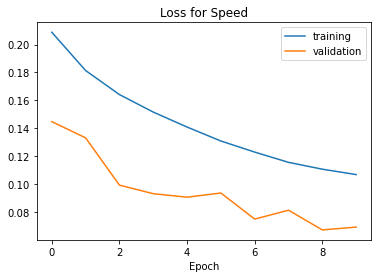

In [41]:

# TRAIN SPEED MODEL
speed_model = nvidia_model()
batch_size = 172
steps_per_epoch = 4*X_train.size/batch_size
speed_history = speed_model.fit(speed_batch_generator(X_train, y_train, batch_size,
                                                      1),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data=speed_batch_generator(
                                    X_valid, y_valid, batch_size, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1)

from sklearn.metrics import mean_squared_error, r2_score
# ANGLE PREDICTIONS BASED ON VALIDATION DATA

x_validTest, y_validTest = next(
    speed_batch_generator(X_valid, y_valid, 1000, 0))
Y_pred = speed_model.predict(x_validTest)
MSE_speed = mean_squared_error(y_validTest, Y_pred)
print(MSE_speed)

speed_model_name = "speed_model_" + "{0:.5f}".format(MSE_speed) + ".h5"
speed_models_path = os.path.join("models", speed_model_name)
speed_model.save(speed_models_path)

plt.plot(speed_history.history['loss'])
plt.plot(speed_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss for Speed')
plt.xlabel('Epoch')
plt.savefig(os.path.join("figures","speed_loss_" + "{0:.5f}".format(MSE_speed) + ".png"))
